In [8]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import fastmri
import torch
import xml.etree.ElementTree as etree
sys.path.append('../../src/')

from tqdm import tqdm
from fastmri.data import transforms as T
from fastmri.data.mri_data import et_query

# custom scripts
import mri_cs
from helpers import calculate_metrics

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

layout = go.Layout(template="plotly_dark")
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
py.init_notebook_mode()

In [5]:
DATA_PATH = '../../data/FastMRIData/singlecoil_train/'
FILE_SAMPLE = DATA_PATH + 'file1001287.h5'

hf = h5py.File(FILE_SAMPLE, mode='r')
list(hf.keys())
dict(hf.attrs)
n_slice = 20
crop_size = (320, 320)

et_root = etree.fromstring(hf["ismrmrd_header"][()])
# extract target image width, height from ismrmrd header
enc = ["encoding", "encodedSpace", "matrixSize"]
img_dims = (
    int(et_query(et_root, enc + ["x"])),
    int(et_query(et_root, enc + ["y"])),
)

volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[n_slice]
slice_kspace_tensor = T.to_tensor(volume_kspace[n_slice])

['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']

{'acquisition': 'CORPD_FBK',
 'max': 0.0004624860345092124,
 'norm': 0.1396935333699368,
 'patient_id': '6999a1ffb63756b29125b8779ce2c956620ff82c62700fe687d4a0d823b066b8'}

# Fully sampled slice 

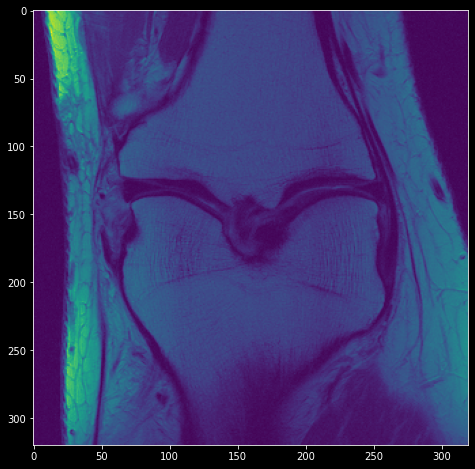

In [6]:
fully_sampled = hf["reconstruction_rss"][()][n_slice]
_ = plt.imshow(fully_sampled)

# Crop image for reconstruction

In [7]:
cropped_kspace = T.complex_center_crop(slice_kspace_tensor, crop_size)
cropped_kspace.shape

torch.Size([320, 320, 2])

# Create Mask

(320, 320)

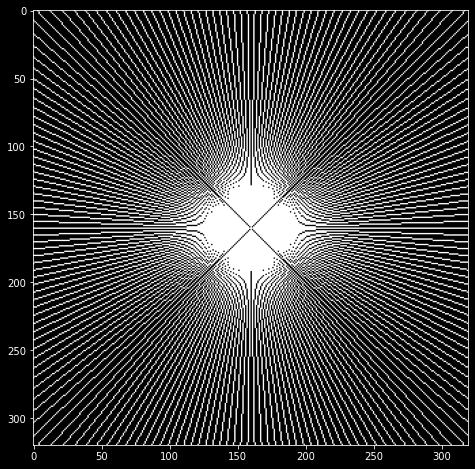

In [23]:
rows, cols, _ = cropped_kspace.shape
rows,cols

angles = np.linspace(0, np.pi, 100)
samples_rows, i, j = mri_cs.radial_lines_samples_rows(rows=rows, columns=cols, angles=angles)

I = np.zeros(shape=[rows * cols,])
I[samples_rows] = 1
I = np.reshape(I, [rows, cols], order="F").copy()
_ = plt.imshow(np.fft.fftshift(I), cmap='gray')

In [37]:
artificial_kspace = np.fft.fft2(fully_sampled)

In [38]:
def get_proportion(f_sampled, u_sampled):
    prop = np.array(u_sampled).flatten().shape[0] / np.array(f_sampled).flatten().shape[0]
    return prop
    
b = artificial_kspace.flatten()[samples_rows]
b.shape
get_proportion(cropped_kspace, b)
b

(29040,)

0.141796875

array([ 7.34057090e+00+0.j        ,  6.47224207e-01-0.56162807j,
       -2.39868951e-03-0.26333158j, ..., -3.51456000e-01+0.32635787j,
       -3.50168556e-01+0.21289064j,  4.88316455e-02+0.31372766j])

# FastMRI K-space

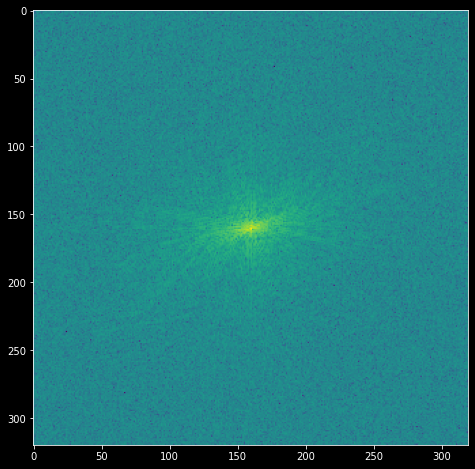

In [54]:
abs_kspace = fastmri.complex_abs(cropped_kspace)
_ = plt.imshow(np.log(abs_kspace + 1e-9))
# _ = plt.imshow(abs_kspace)

# Artificial k-space from FFT2

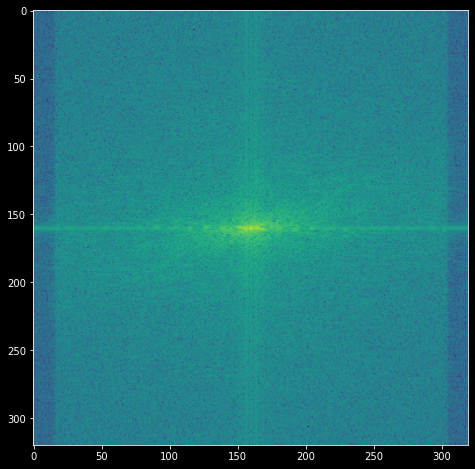

In [53]:
# _ = plt.imshow(np.abs(np.fft.fftshift(artificial_kspace)))
_ = plt.imshow(np.log(np.abs(np.fft.fftshift(artificial_kspace)) + 1e-9))

# Zero filled reconstruction

<module 'helpers' from '../../src/helpers.py'>

PSNR: 97.18460377657279
SSIM: 0.7658861253974969
SNR: 15.70974540908868
MSE: 1.9122277764829932e-10


../../src/helpers.py:55: UserWarning:

Inputs have mismatched dtype.  Setting data_range based on im_true.



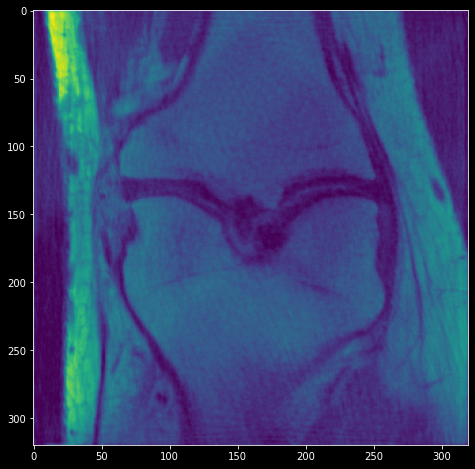

In [67]:
from helpers import zero_fill
import helpers
reload(helpers)

zero_filled = zero_fill(b, samples_rows, rows, cols)
# zero_filled = np.fft.fftshift(zero_filled)
_ = plt.imshow(np.abs(zero_filled))
_ = helpers.calculate_metrics(fully_sampled, np.abs(zero_filled))

# Prefiltering L1 Minimization

In [69]:
from importlib import reload
import mri_cs
reload(mri_cs)

filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]

if isinstance(b, torch.Tensor):
    b = b.cpu().detach().numpy()
    
rows, cols = masked_kspace.shape

tol_cg = 1e-10
maxiter_cg = 2 * b.size

print("B:", b.shape, "Samples Rows:", samples_rows.shape)
recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, number_jobs=1, verbose=True)

<module 'mri_cs' from '../../src/mri_cs.py'>

B: (29040,) Samples Rows: (29040,)
####### Reconstructing filtered image 1 of 3 #######
{'A_': <function prefiltering.<locals>.A at 0x7f0ea0fbd820>, 'Ah': <function prefiltering.<locals>.Ah at 0x7f0ea0fbdc10>, 'b': array([0.        +0.j        , 0.        +0.j        ,
       0.        -0.j        , ..., 0.01211385+0.01440253j,
       0.00781037+0.01406238j, 0.0123686 -0.00155365j]), 'p': 1, 'initial_mu': 1.0, 'mu_reduction_function': <function <lambda> at 0x7f0ea0fbd700>, 'min_mu': 1e-08, 'x0': array([], dtype=float64), 'N': 102400, 'maxiterperstage': 30, 'maxiter_cg': 58080, 'tol_cg': 1e-10, 'information_string': ' image 1 of 3', 'phi': array([], dtype=float64), 'tau': 0.1, 'verbose': True, 'custom_cg': <function lgmres at 0x7f0f10c214c0>}
Starting stage 1 image 1 of 3
    Iteration 1 image 1 of 3
Starting stage 2 image 1 of 3
    Iteration 1 image 1 of 3
Starting stage 3 image 1 of 3
    Iteration 1 image 1 of 3
Starting stage 4 image 1 of 3
    Iteration 1 image 1 of 3
Starting sta

    Iteration 27 image 2 of 3
    Iteration 28 image 2 of 3
    Iteration 29 image 2 of 3
Elapsed time: 146.66280722618103s
Finished reconstructing filtered image 2 of 3
####### Reconstructing filtered image 3 of 3 #######
{'A_': <function prefiltering.<locals>.A at 0x7f0ea0fbd820>, 'Ah': <function prefiltering.<locals>.Ah at 0x7f0ea0fbdc10>, 'b': array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00-0.j        , ...,  5.65876932e-04-0.00047595j,
        4.14291013e-04-0.0002301j , -3.05098641e-05-0.00024289j]), 'p': 1, 'initial_mu': 1.0, 'mu_reduction_function': <function <lambda> at 0x7f0ea0fbd700>, 'min_mu': 1e-08, 'x0': array([], dtype=float64), 'N': 102400, 'maxiterperstage': 30, 'maxiter_cg': 58080, 'tol_cg': 1e-10, 'information_string': ' image 3 of 3', 'phi': array([], dtype=float64), 'tau': 0.1, 'verbose': True, 'custom_cg': <function lgmres at 0x7f0f10c214c0>}
Starting stage 1 image 3 of 3
    Iteration 1 image 3 of 3
Starting stage 2 image 3

PSNR: 97.98129894088513
SSIM: 0.8126808059631574
SNR: 16.50644057340102
MSE: 1.5917325810623952e-10


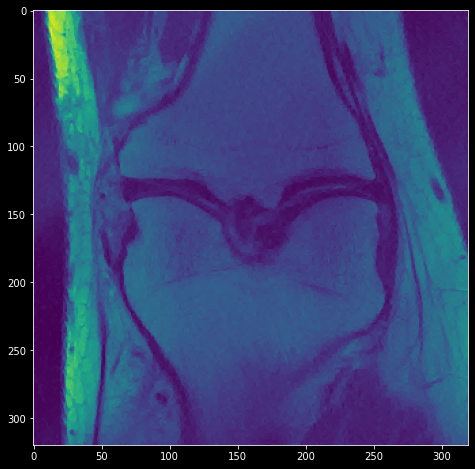

In [70]:
_ = plt.imshow(np.abs(recon))
_ = helpers.calculate_metrics(fully_sampled, np.abs(recon))